### Задание 1:
Выберите 2 любые компании, которые имеют листинг на фондовом рынке США. Выгрузите дневные данные начиная с 2017 по настоящее время по этим 2-м 
компаниям и сформируйте датасет для временного ряда (итого у вас 2 датасета). 
Цель задания - проведите исследование и статистический анализ временного ряда по сформированным датасетам, посчитайте все основные статистики для 
временного ряда, превратите ваши временные ряды в стационарные и сформируйте отчет с выводами и визуализациями в jupyter notebook’e.

----

### Решение задания 1

Выполним импорт необходимых библиотек

In [53]:
import yfinance as yf
from datetime import date as dt
import plotly.graph_objects as go
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kstest, normaltest
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

from prophet import Prophet

from itertools import product

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, mean_squared_log_error
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

#### 1.1 Исследование и статистический анализ временного ряда изменений стоимости ценных бумаг компании EPAM

Для исследования и статистического анализа выберем ценную бумагу компании EPAM (ticker="EPAM"), единственной компании с белорусскими корнями, которая торгуется на фондовой бирже США

Для извлечения данных об изменении стоимости ценной бумаги используем функцию get_price_data. Зададим период с 01.01.2017 до 31.03.2025 включительно (поэтому последней датой укажем 01.04.2025).

In [54]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2025-4-1')
    return tickerDf.iloc[:, :5]

In [55]:
df_epam = get_price_data(ticker='EPAM')

In [56]:
df_epam.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-25 00:00:00-04:00,179.289993,180.580002,177.699997,178.990005,500000
2025-03-26 00:00:00-04:00,179.339996,179.770004,175.820007,176.919998,391100
2025-03-27 00:00:00-04:00,176.300003,176.619995,173.570007,174.229996,495200
2025-03-28 00:00:00-04:00,173.279999,173.509995,167.000000,168.929993,634000
2025-03-31 00:00:00-04:00,167.089996,169.910004,164.000000,168.839996,669700


Выполним проверку на выпадающие значения. Такие отсутствуют.

In [57]:
df_epam.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Для визуализации изменения стоимости ценной бумаги используем свечную диаграмму, генерируемую с помощью функции plot_candlestick

In [58]:
def plot_candlestick(df, ticker=None):
    fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
    )])

    fig.update_layout(
        title=f'Candlestick chart - {ticker}',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        template='plotly_white'
    )
    
    fig.show()

In [59]:
plot_candlestick(df_epam, ticker="EPAM")

Используя приведенную выше диаграмму, отмечаем наличие общего восходящего тренда. Однако этот тренд разбивается на два четких периода: период восходящего тренда вплоть до 2022 года, который затем сменился периодом нисходящего тренда, продолжащимся до настоящего времени. Каждый из этих периодов включал циклы роста и снижения стоимости акций. Максимальных значений стоимость акций достигала в конце 2021 года, когда она достигала 715 долл. Минимальные значения стоимости, учитывая общий восходящий тренд, наблюдались в начале выбранного временного отрезка, т.е. в 2017 году. За период с 2017 г. по 2022 г. цена акций возросла более чем в 10 раз. Но с 2022 г. она упала более чем в 4 раза.

Проведем статистический анализ временного ряда.

In [60]:
epam_close = df_epam["Close"]
epam_close.describe()

count    2072.000000
mean      252.317553
std       139.284608
min        63.660000
25%       142.502495
50%       229.084999
75%       319.637497
max       717.489990
Name: Close, dtype: float64

Прежде всего, отмечаем расхождение среднего значения и медианы, что и предполагалось, поскольку распределение данных, скорее всего, не является нормальным. Отмечаем заметное отличие максимального значения от значений процентилей (25 %, 50 % и 75 %), что свидетельствует о наличии резких скачков стоимости акций, приводивших к достижению максимальных значений. Это подтверждается и приведенной выше свечной диаграммой. Значение стандартного отклонения близко к среднему значению, что свидетельствует о значительных колебаниях стоимости акций.

Выполним визуализацию распределения изменения стоимости выбранной ценной бумаги

In [61]:
def values_distribution(df, ticker):
    plt.figure(figsize=(10, 4))
    sns.histplot(df, kde=True, bins=50)
    plt.title(f'Распределение цены закрытия {ticker}')
    plt.xlabel('Цена закрытия')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

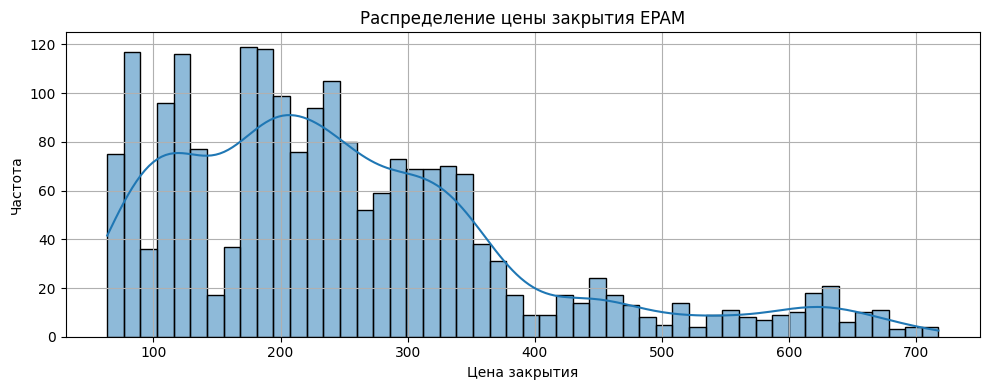

In [62]:
values_distribution(epam_close, "EPAM")

Отмечаем отсутствие нормального распределения. Такое распределение является ожидаемым, учитывая общий восходящий тренд и период анализа, который не охватывает весь период после IPO данной компании. Если бы был охвачен весь период торгов, мы бы с большой вероятностью обнаружили начальный период низкой стоимости данной ценной бумаги, что привело бы к распределению, более близкому к нормальному.

Подтвердим эти выводы с помощью математических тестов на нормальность распределения данных

In [63]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

In [64]:
def normality_tests(df):
    normal_args = (np.mean(df), np.std(df))

    # 1. Тест Шапиро–Уилка
    print(f"Checking normality with Shapiro-Wilk test: {is_normal(shapiro(df))}")  

    # 2. Тест Д’Агостино и Пирсона (normaltest)
    print(f"Checking normality with D'Agostino-Pearson test: {is_normal(normaltest(df))}")  

    # 3. Тест Андерсона-Дарлинга (из пакета statsmodels)
    print(f"Checking normality with Anderson-Darling test: {is_normal(normal_ad(df))}")  

    # 5. Критерий Колмогорова–Смирнова против нормального распределения с параметрами, оценёнными из данных
    print(f"Checking normality with Kolmogorov-Smirnov test: {is_normal(kstest(df,
                       cdf='norm',
                       args=normal_args))}")

In [65]:
normality_tests(epam_close)

Checking normality with Shapiro-Wilk test: Not Normal
Checking normality with D'Agostino-Pearson test: Not Normal
Checking normality with Anderson-Darling test: Not Normal
Checking normality with Kolmogorov-Smirnov test: Not Normal


Все выполненные статистические тесты на нормальность подтверждают, что распределение данных не является нормальным. Визуализируем этот вывод с помощью QQ-диаграммы

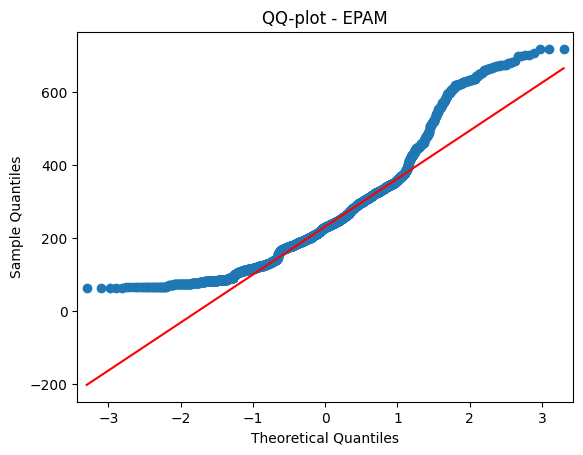

In [66]:
qqplot(epam_close, line='q')
plt.title("QQ-plot - EPAM");

Наличие ярко выраженных "хвостов", отклоняющихся от красной прямой, отражающей нормальное распределение данных, свидетельствует о ненормальном распределении данных.

Оценим статичность временного ряда. Исходя из визуальной оценки, выполненной ранее, мы понимаем, что временной ряд имеет тренд. Более того, судя по всему, присутствует гетероскедастичность вследствие различия величины дисперсии в разных временных периодах (рост и падений акций с разных размахом в разных временных точках). Поэтому исследуемый временной ряд, наверняка, не является стационарным. Однако проверим данное утверждение с помощью критерия Дики-Фуллера

In [67]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [68]:
test_stationarity(epam_close)

Results of Dickey-Fuller Test:
Test Statistic                   -1.758484
p-value                           0.401259
#Lags Used                       12.000000
Number of Observations Used    2059.000000
Critical Value (1%)              -3.433530
Critical Value (5%)              -2.862945
Critical Value (10%)             -2.567518
dtype: float64


Отмечаем, что непреобразованный временной ряд, действительно, нестационарен (p-value = 0,401259), что превышает стандартное пороговое значение, равное 0,05. Учитывая наличие гетероскедатичности, приведем ряд к стационарности, выполнив логарифмическое преобразование временного ряда и вновь оценим ряд на стационарность с помощью критерия Дики-Фуллера:

In [69]:
epam_close_log = np.log(epam_close)
test_stationarity(epam_close_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.141731
p-value                           0.228069
#Lags Used                       12.000000
Number of Observations Used    2059.000000
Critical Value (1%)              -3.433530
Critical Value (5%)              -2.862945
Critical Value (10%)             -2.567518
dtype: float64


Вновь отмечаем, что логарифмически преобразованный временной ряд не является стационарным (p-value = 0,228069), что превышает 0,05. В таком случае проведем дифференцирование на 1 лаг:

In [70]:
epam_close_diff = epam_close_log.diff(1).dropna()
test_stationarity(epam_close_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.407724e+01
p-value                        2.870313e-26
#Lags Used                     1.100000e+01
Number of Observations Used    2.059000e+03
Critical Value (1%)           -3.433530e+00
Critical Value (5%)           -2.862945e+00
Critical Value (10%)          -2.567518e+00
dtype: float64


После дифференцирования на 1 лаг отмечаем резкое снижение значения p-value (менее 0,05). Т.е. ряд стал стационарным. Для такого ряда выполним визуализацию для отображения автокорреляции и частичной автокорреляции с целью анализа сезонности.

In [71]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

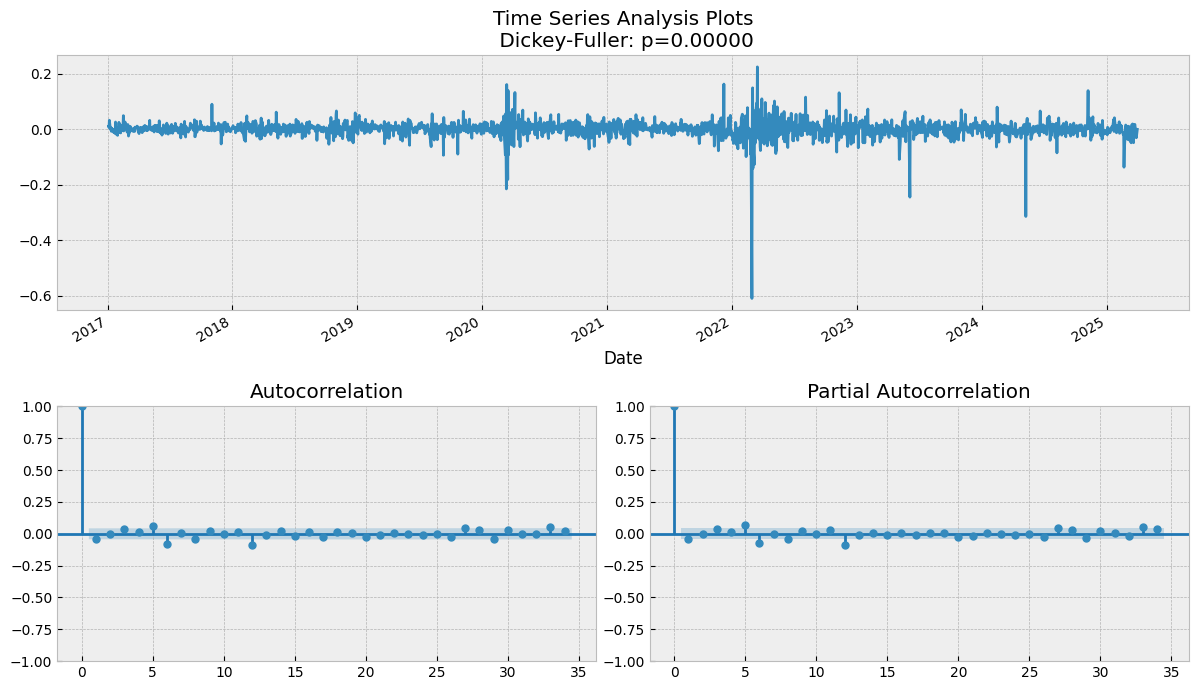

In [72]:
tsplot(epam_close_diff)

Исходя из приведенных выше диаграмм, отмечаем отсутствие выраженной сезонности для временного ряда, что характерно для временных рядов изменения стоимости биржевых активов и что противоречило бы сути рынка ценных бумаг (главной особенностью рынков акций и облигаций является отсутствие однозначного паттерна изменения их стоимости; в противном случае, они бы легко предсказывались, что делало бы торговлю ценными бумагами бессмысленной). Можно обнаружить едва заметные пики для лагов 6 и 12, это их величина пренебрежимо мала, чтобы ее можно было учитывать в качестве параметров сезонности временного ряда.

Выполним декомпозицию временного ряда. В данной модели следует указать период сезонности. Поскольку, как мы установили выше, сезонность отсутствует, этот параметр становится бессмысленным. Однако чтобы иметь возможность разложить ряд, зададим значение периода, равное 252 (число рабочих дней в году, когда осуществляются торги ценными бумагами).

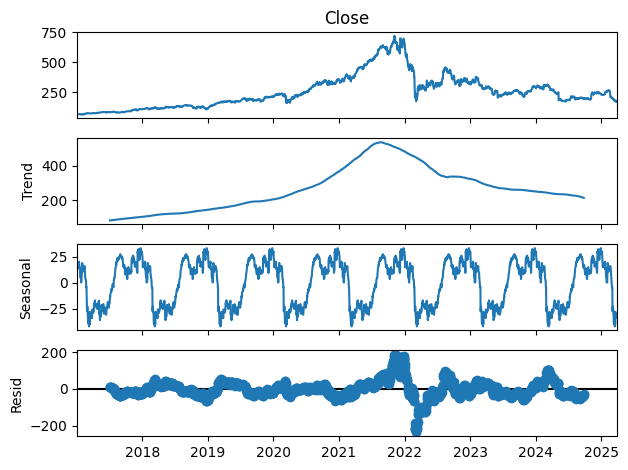

In [73]:
epam_decomposed = seasonal_decompose(epam_close, model='additive', period=252)
epam_decomposed.plot()
plt.show()

Кроме того, выполним декомпозицию временного ряда и с помощью инструмента STL. Также укажем период, равный 252. Параметр seasonal следует подбирать эмпирически. Однако поскольку сезонность в целом отсутствует для исследуемого временного ряда, подставим часто применяемое значение, равное 13, не претендуя на точность.

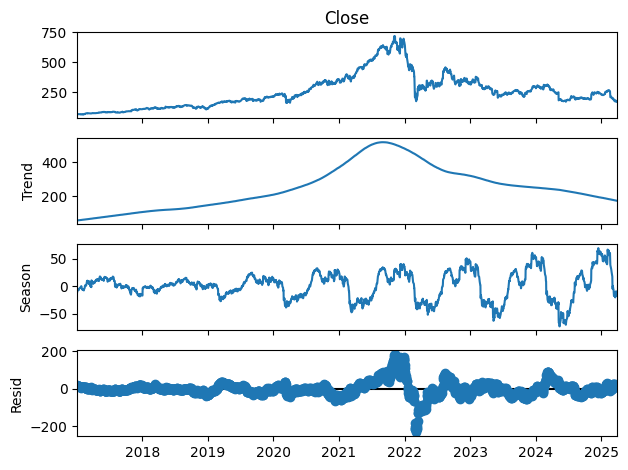

In [74]:
stl_epam = STL(epam_close, period=252, seasonal=13)
res_epam = stl_epam.fit()
res_epam.plot()
plt.show()

На обеих диаграммах отмечаем наличие выраженного тренда. Обе модели показывают наличие слабой сезонности (порядок изменения от -25 до 25 и -50 до 50 соответственно), учитывая изменения стоимости акций в диапазоне от 65 до 715 долл, а также величину остатков - размах колебаний от -200 до 200. Это свидетельствует о том, что выраженная сезонность отсутствует. Величина остатков, которая превышает величину сезонности и сопоставима с величиной тренда, что указывает на наличие факторов, кроме тренда и сезонности, которые оказывают сильное влияние на изменение стоимости данной ценной бумаги. Влияние этих факторов было особенно заметно в период 2021 - 2022 гг.

#### 1.2 Исследование и статистический анализ временного ряда изменений стоимости ценных бумаг компании Novo Nordisk

Ценная бумага фармацевтической компании Novo Nordisk была выбрана в связи с тем, что в последние годы эта компания стала одной из крупнейших по капитализации на фармацевтическом рынке вследствие разработки революционного препарата Оземпик (Ozempic) и его аналога, препарата Веговы (Vegovy). Вывод этих препаратов на рынок привел к тому, что компания Novo Nordisk за считанные годы превратилась из компании 2 - 3-го эшелона в крупнейшую фармацевтическую компанию мира, бюджет которой сопоставим с бюджетом страны ее происхождения (Дания). Поэтому было бы интересно изучить временной ряд изменения стоимости акций этой компании.

Подготовим датасет и проверим на наличие пропущенных значений

In [75]:
df_novo = get_price_data(ticker='NVO')
df_novo.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,15.441483,15.471318,15.224118,15.309359,9445800
2017-01-04 00:00:00-05:00,15.394603,15.467059,15.317885,15.420176,5143800
2017-01-05 00:00:00-05:00,15.680161,15.803762,15.624754,15.795238,4803800
2017-01-06 00:00:00-05:00,15.667376,15.675901,15.552302,15.616232,5227400
2017-01-09 00:00:00-05:00,15.509677,15.603443,15.411649,15.556560,3724600


In [76]:
df_novo.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Пропущенные данные отсутствуют. Построим свечную диаграмму

In [77]:
plot_candlestick(df_novo, ticker="NVO")

Используя приведенную выше диаграмму, отмечаем наличие общего восходящего тренда. Однако этот тренд разбивается на два четких периода: период восходящего тренда вплоть до середниы 2024 года, который затем сменился периодом нисходящего тренда, продолжащимся до настоящего времени. Каждый из этих периодов включал многочисленные циклы роста и снижения стоимости акций. Максимальных значений стоимость акций достигала в июне-июле 2024 года, когда она составляла около 145 долл. Минимальные значения стоимости, учитывая общий восходящий тренд, наблюдались в начале выбранного временного отрезка, т.е. в 2017 году (около 15 долл.). За период с 2017 г. по середину 2024 г. цена акций возросла почти в 10 раз. Но с середины 2024 г. она снизилась более чем в 2 раза.

Выполним статистический анализ временного ряда.

In [78]:
novo_close = df_novo["Close"]
novo_close.describe()

count    2072.000000
mean       49.771957
std        34.280773
min        14.056311
25%        22.343396
50%        33.081039
75%        68.654179
max       144.041077
Name: Close, dtype: float64

Отмечаем расхождение среднего значения и медианы, что и предполагалось, поскольку распределение данных, скорее всего, не является нормальным. Среднее значение сильно превышает медиану, поскольку данные сильно скошены вправо (это свидетельствует о выраженном скачке стоимости акций, что сказалось на среднем значении). Отмечаем заметное отличие максимального значения и 75 % процентиля от значений других процентилей (25 %, 50 %), что также подтверждает наличие резкого роста стоимости акций. Это отображает и приведенная выше свечная диаграмма. Значение стандартного отклонения сопоставимо со средним значением, что свидетельствует о значительных колебаниях стоимости акций.

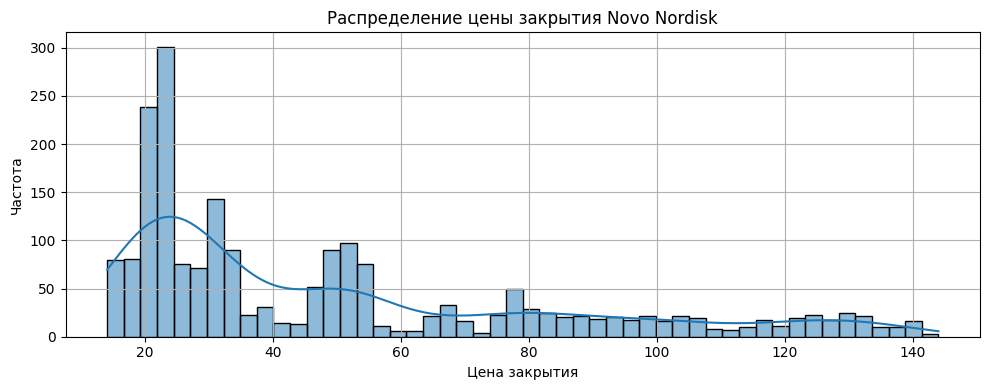

In [79]:
values_distribution(novo_close, "Novo Nordisk")

Отмечаем отсутствие нормального распределения (о чем предполагалось выше). Такое распределение является ожидаемым, учитывая общий восходящий тренд и период анализа, который не охватывает весь период после IPO данной компании. В целом, наблюдается очень длинный правый хвост, а большая часть данных охвачена диапазоном от 15 до 40 долл. Это свидетельство длительного периода низкой стоимости акции компании и стремительного ее взлета.

Подтвердим вывод об отсутствии нормального распределения данных с помощью статистических критериев

In [80]:
normality_tests(novo_close)

Checking normality with Shapiro-Wilk test: Not Normal
Checking normality with D'Agostino-Pearson test: Not Normal
Checking normality with Anderson-Darling test: Not Normal
Checking normality with Kolmogorov-Smirnov test: Not Normal


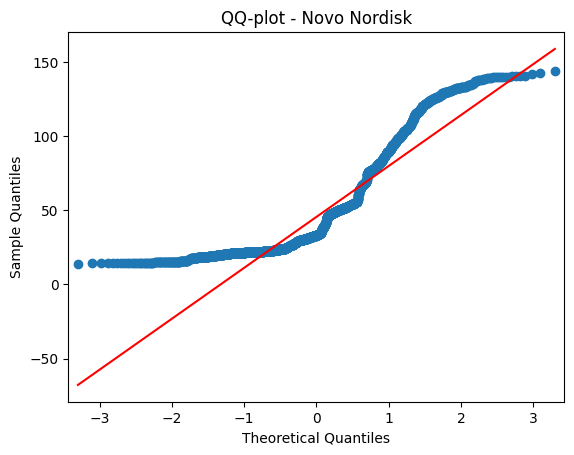

In [81]:
qqplot(novo_close, line='q')
plt.title("QQ-plot - Novo Nordisk");

Статистические критерии и QQ-диаграмма однозначно указывают на отсутствие нормальности в распределении значений во временном ряду.

Оценим статичность временного ряда. Исходя из визуальной оценки, выполненной ранее, мы понимаем, что временной ряд имеет тренд. Более того, судя по всему, присутствует гетероскедастичность вследствие различия величины дисперсии в разных временных периодах (рост и падений акций с разных размахом в разных временных точках). Поэтому исследуемый временной ряд, наверняка, не является стационарным. Однако проверим данное утверждение с помощью критерия Дики-Фуллера

In [82]:
test_stationarity(novo_close)

Results of Dickey-Fuller Test:
Test Statistic                   -0.982739
p-value                           0.759508
#Lags Used                        3.000000
Number of Observations Used    2068.000000
Critical Value (1%)              -3.433516
Critical Value (5%)              -2.862939
Critical Value (10%)             -2.567515
dtype: float64


Отмечаем, что непреобразованный временной ряд, действительно, нестационарен (p-value = 0,759508), что превышает стандартное пороговое значение, равное 0,05. Учитывая наличие гетероскедатичности, приведем ряд к стационарности, выполнив логарифмическое преобразование временного ряда и вновь оценим ряд на стационарность с помощью критерия Дики-Фуллера:

In [83]:
novo_close_log = np.log(novo_close)
test_stationarity(novo_close_log)

Results of Dickey-Fuller Test:


Test Statistic                   -1.242631
p-value                           0.654993
#Lags Used                        0.000000
Number of Observations Used    2071.000000
Critical Value (1%)              -3.433511
Critical Value (5%)              -2.862937
Critical Value (10%)             -2.567513
dtype: float64


Вновь отмечаем, что логарифмически преобразованный временной ряд не является стационарным (p-value = 0,654994), что превышает 0,05. В таком случае проведем дифференцирование на 1 лаг:

In [84]:
novo_close_diff = novo_close_log.diff(1).dropna()
test_stationarity(novo_close_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -47.037278
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2070.000000
Critical Value (1%)              -3.433513
Critical Value (5%)              -2.862937
Critical Value (10%)             -2.567514
dtype: float64


После дифференцирования на 1 лаг отмечаем резкое снижение значения p-value (менее 0,05). Т.е. ряд стал стационарным. Для такого ряда выполним визуализацию для отображения автокорреляции и частичной автокорреляции с целью анализа сезонности. 

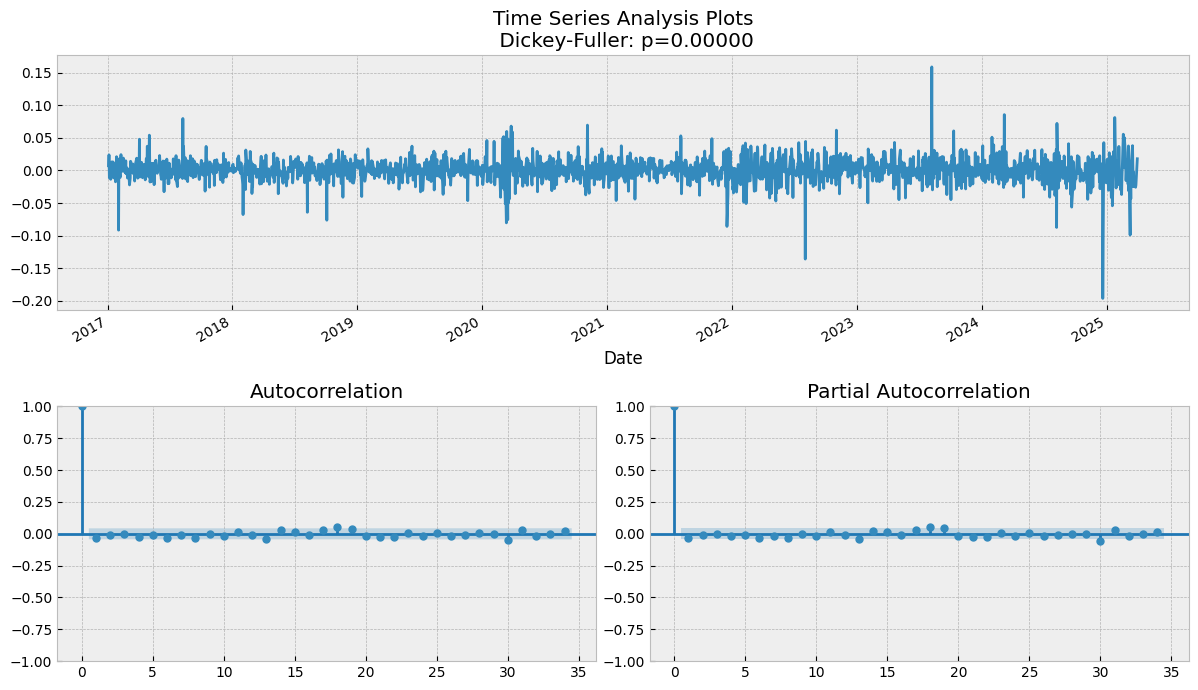

In [85]:
tsplot(novo_close_diff)

Исходя из приведенных выше диаграмм, отмечаем отсутствие выраженной сезонности для временного ряда.

Выполним декомпозицию временного ряда. В данной модели следует указать период сезонности. Поскольку, как мы установили выше, сезонность отсутствует, этот параметр становится бессмысленным. Однако чтобы иметь возможность разложить ряд, зададим значение периода, равное 252 (число рабочих дней в году, когда осуществляются торги ценными бумагами).

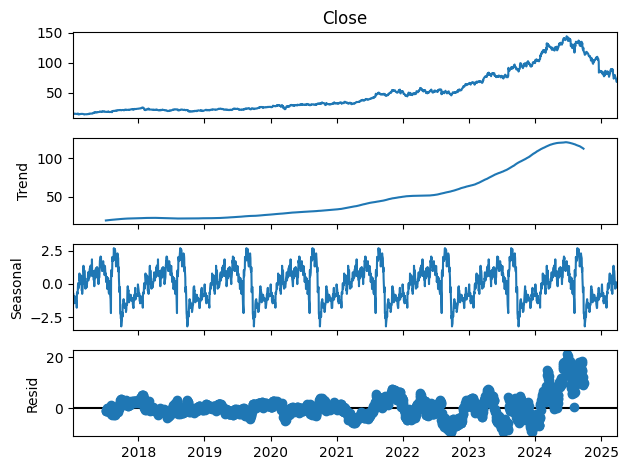

In [86]:
novo_decomposed = seasonal_decompose(novo_close, model='additive', period=252)
novo_decomposed.plot()
plt.show()

Кроме того, выполним декомпозицию временного ряда и с помощью инструмента STL. Также укажем период, равный 252. Параметр seasonal следует подбирать эмпирически. Однако поскольку сезонность в целом отсутствует для исследуемого временного ряда, подставим часто применяемое значение, равное 13, не претендуя на точность.

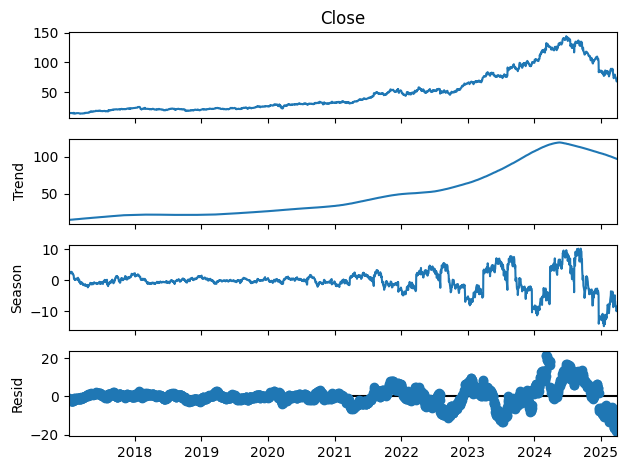

In [87]:
stl_novo = STL(novo_close, period=252, seasonal=13)
res_novo = stl_novo.fit()
res_novo.plot()
plt.show()

На обеих диаграммах отмечаем наличие выраженного тренда. Обе модели показывают наличие слабой сезонности (порядок изменения от -2.5 до 2.5 и -10 до 10 соответственно), учитывая изменения стоимости акций в диапазоне от 15 до 145 долл, а также величину остатков - размах колебаний от -20 до 20. Это свидетельствует о том, что выраженная сезонность отсутствует. Величина остатков, которая превышает величину сезонности и сопоставима с величиной тренда, что указывает на наличие факторов, кроме тренда и сезонности, которые оказывают сильное влияние на изменение стоимости данной ценной бумаги. Влияние этих факторов было особенно заметно в период 2022 - 2025 гг. (период активного роста и падения стоимости акций).

### Задание 2:
Выберите 1 из 2-ух временных рядов из задания 1 и сделайте прогноз на ближайший месяц-квартал-полугодие  и год. Модель выбирать исходя из ваших 
предположений и умозаключений. Необходимо обосновать почему была выбрана та или иная модель и на каких основаниях, в чем она лучше и почему она 
подходит. Оценить качество прогноза согласно выбранной метрике, проверить качество на отложенной выборке путем применения TimeSeriesSplit. 
Сформировать отчет с выводами и визуализациями в jupyter notebook’e.

----


#### Решение

Для исследования выберем временной ряд для акции Novo Nordisk. Учитывая результаты проведенного ранее анализа, можно сделать следующие заключения о потенциальном выборе модели, приемлемой для моделирования данного временного ряда. Прежде всего, приемлемым является моделирование с помощью библиотеки Prophet. Данная модель обладает широким диапазоном возможности, она устойчива к наличию выбросов, выпадающих значений (в нашем датасете представлены данные только за рабочие дни, без выходных). Кроме того, она позволяет учитывать либо не учитывать наличие сезонности, а также проводить моделирование на разные интервалы времени в будущем. Можно использовать модель ARIMA, подобрав значения гиперпараметров p, d, q. Однако следует понимать, что предсказательные возможности этой модели сильно ограничены 1-3 лагами, что недостаточно для указанных интервалов прогнозирования: месяц, квартал, полугодие и год. Что касается иных моделей, то модель ARMA не пригодна, поскольку выбранный временной ряд требует дифференцирования, что невозможно в этой модели. Модель SARIMA считается избыточной, поскольку, как было установлено выше, для временного ряда отсутствует сезонность (при исключении сезонности модель SARIMA вырождается в модель ARIMA). Модели на основе классических моделей машинного обучения, например, горизонт прогнозирования моделей линейной регрессии небольшой, кроме того, эта модель плохо улавливают резкие изменения тренда. Бустинг-модели могли бы неплохо предсказывать исторические данные, однако они плохо прогнозируют временные ряды на основе исторических данных. В связи с этим оптимальным видится использование модели Prophet. Также попытаемся использовать модель ARIMA, предварительно подобрав значения гиперпараметров.

#### 1.1 Прогнозирование с помощью модели Prophet

Подготовим датасет для модели Prophet

In [88]:
novo_prophet = novo_close.reset_index()
novo_prophet.columns = ['ds', 'y']
novo_prophet['ds'] = pd.to_datetime(novo_prophet['ds']).dt.tz_localize(None)


In [89]:
novo_prophet.tail()

,ds,y
2067,2025-03-25,72.432808
2068,2025-03-26,70.592468
2069,2025-03-27,69.047363
2070,2025-03-28,68.201004
2071,2025-03-31,69.440002


Прежде чем проводить прогнозирование с использованием модели Prophet оценим качество ее прогнозов на исторических данных. Оценку качества будем выполнять на фолдах временного ряда, сгенерированных с помощью инструмента TimeSeriesSplit (n_splits=10). Получим оценки MAPE и RMSE для каждого фолда, которые затем усредним по всему временному ряду. 

In [90]:
import logging
#import cmdstanpy

# Отключаем логирование cmdstanpy
cmdstanpy_logger = logging.getLogger('cmdstanpy')
cmdstanpy_logger.disabled = True

tscv = TimeSeriesSplit(n_splits=10)
metrics = []

for train_idx, test_idx in tscv.split(novo_prophet):
    train = novo_prophet.iloc[train_idx]
    test = novo_prophet.iloc[test_idx]
    
    model = Prophet(
        seasonality_mode="multiplicative",
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=False)
    
    model.fit(train)
    
    # Прогноз на длину test
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Оценка качества
    pred = forecast.iloc[-len(test):]['yhat']
    true = test['y']
    
    mape = np.mean(np.abs((true - pred) / true)) * 100
    rmse = np.sqrt(mean_squared_error(true, pred))
    metrics.append({'MAPE': mape, 'RMSE': rmse})
    print(f"MAPE для fold: {mape:.2f}%, RMSE для fold: {rmse:.2f}")

# Средние метрики
avg_mae = np.mean([m['MAPE'] for m in metrics])
avg_rmse = np.mean([m['RMSE'] for m in metrics])
print(f"\nСредний MAPE: {avg_mae:.2f}%")
print(f"Средний RMSE: {avg_rmse:.2f}")

MAPE для fold: 10.81%, RMSE для fold: 2.97
MAPE для fold: 11.44%, RMSE для fold: 2.90
MAPE для fold: 21.66%, RMSE для fold: 5.44
MAPE для fold: 10.08%, RMSE для fold: 3.41
MAPE для fold: 5.83%, RMSE для fold: 2.45
MAPE для fold: 18.40%, RMSE для fold: 9.67
MAPE для fold: 12.81%, RMSE для fold: 8.18
MAPE для fold: 27.40%, RMSE для fold: 23.28
MAPE для fold: 17.67%, RMSE для fold: 23.29
MAPE для fold: 38.50%, RMSE для fold: 42.67

Средний MAPE: 17.46%
Средний RMSE: 12.43


Полученные данные демонстрируют довольно плохие метрики качества. При предсказаниях модель в среднем ошибалась в 17 % случаев. Однако надо учитывать профиль данных. Первая половина временного ряда представляет собой ряд с небольшим восходящим трендом и небольшой волатильностью. Этот интервал довольно нелохо предсказывается моделью. Однако для второй половины с резким ростом, а затем резким падением стоимости акций метрики качества предсказания сильно ухудшаются; MAPE достигает почти 40 %. Модель не улавливает сильных изменений дисперсии. Включение годовой сезонности практически не изменяет значения метрик (что подтверждает сделанный ранее вывод об отсутствии сезонности). Именно поэтому предсказания модели на будущие периоды, судя по всему, будут плохими.

Прогноз с использованием модели Prophet

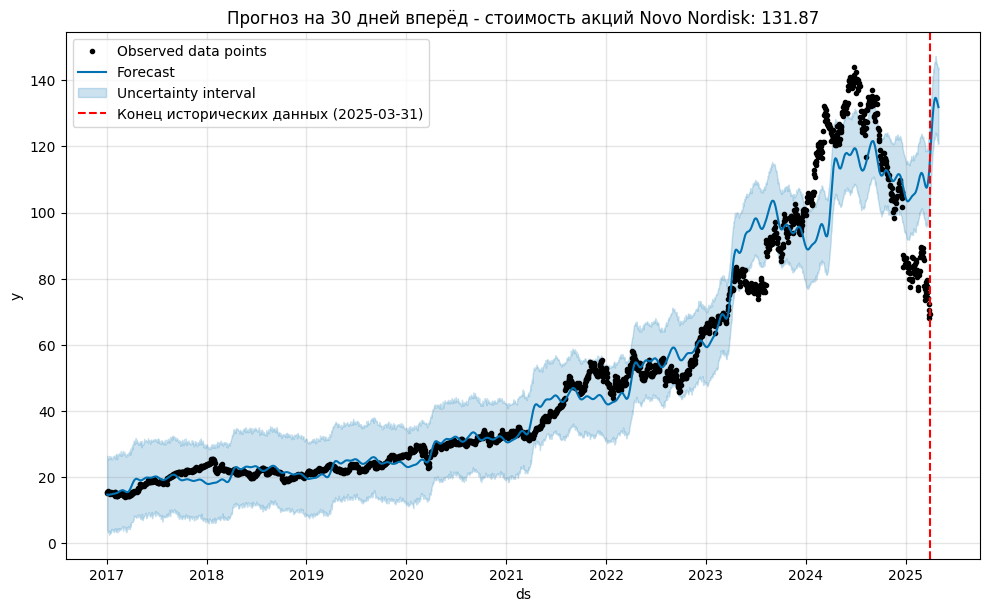

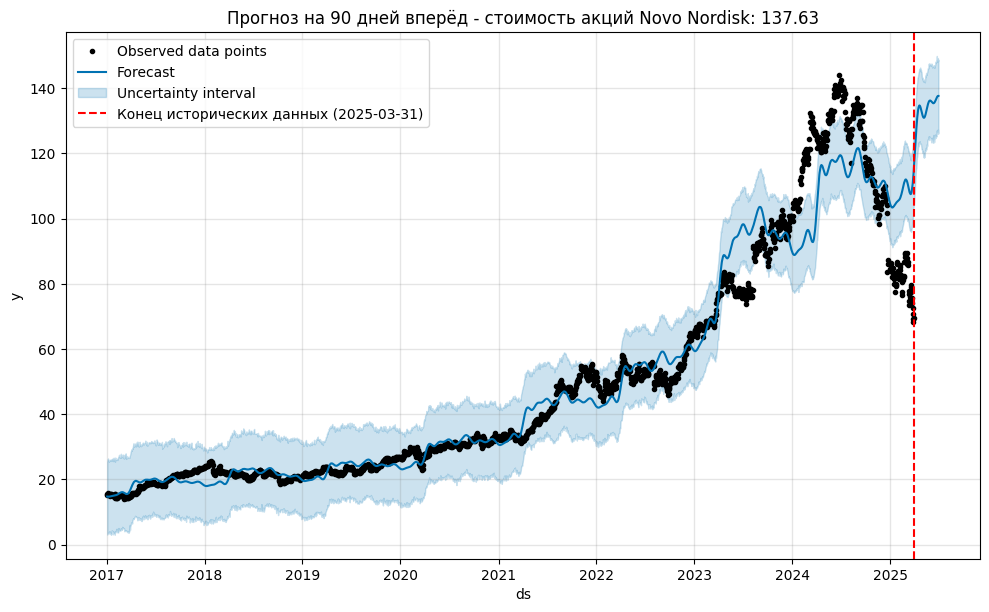

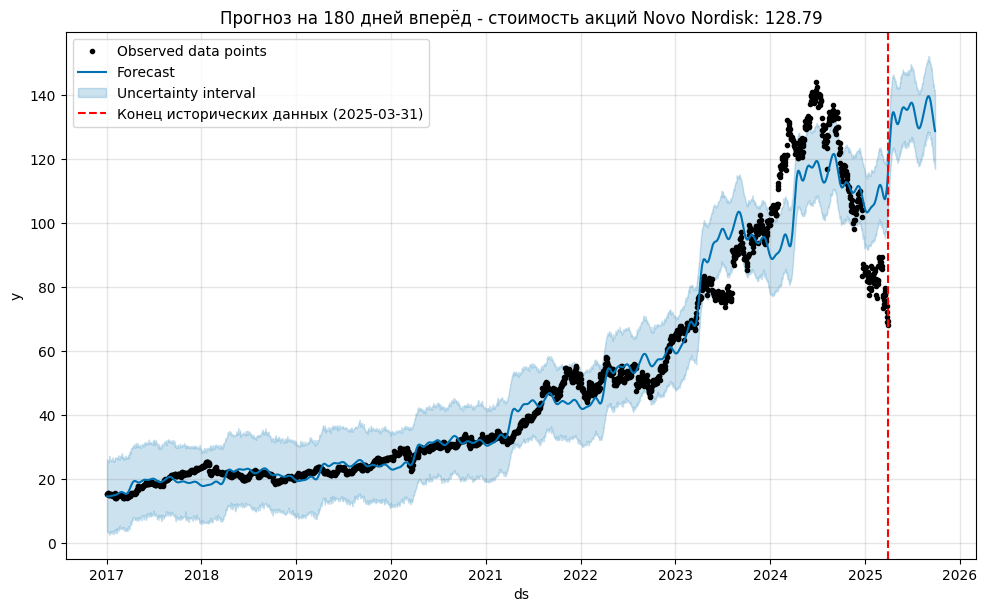

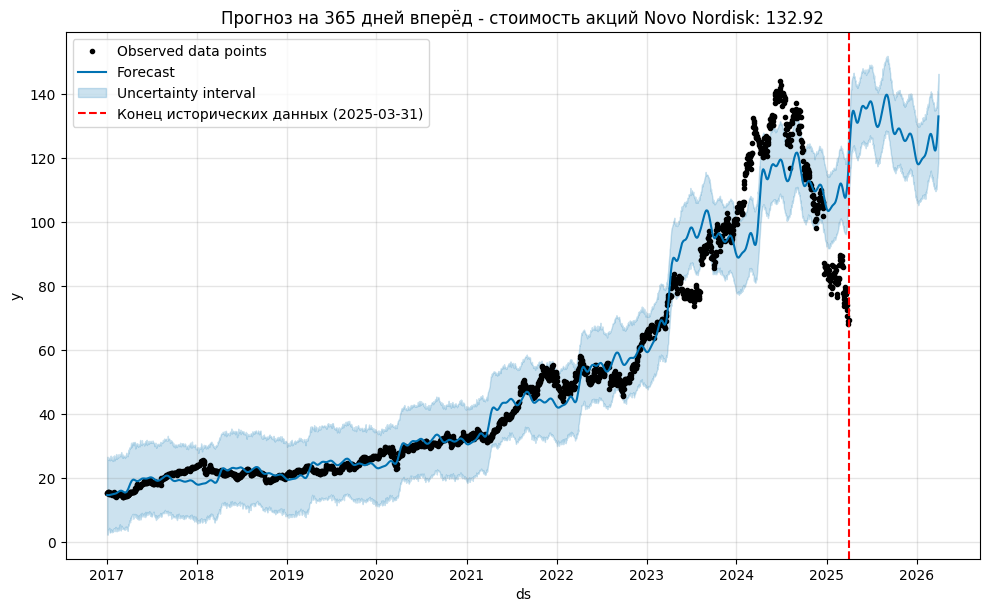

In [91]:
# Инициализация модели
model = Prophet(
    seasonality_mode="multiplicative",
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False
)

model.fit(novo_prophet)

# Прогноз на 30, 90, 180, 365 дней
periods = [30, 90, 180, 365]
last_date = novo_prophet['ds'].max()

for p in periods:
    future = model.make_future_dataframe(periods=p)
    forecast = model.predict(future)
    
    # Визуализация
    fig = model.plot(forecast)
    plt.axvline(x=last_date, color='red', linestyle='--', 
                label=f'Конец исторических данных ({last_date.date()})')
    plt.title(f'Прогноз на {p} дней вперёд - стоимость акций Novo Nordisk: {forecast.iloc[-1]['yhat']:.2f}')
    plt.legend()
    plt.show()

Исходя из представленных выше диаграмм, модель прогнозирует восходящий тренд на 30 и 90 дней вперед, с последущим снижением стоимости акций через 180 дней и повышением через 365 дней. 

Выведем компоненты временного ряда. Модель Prophet указывает на наличие незначительной годовой сезонности.

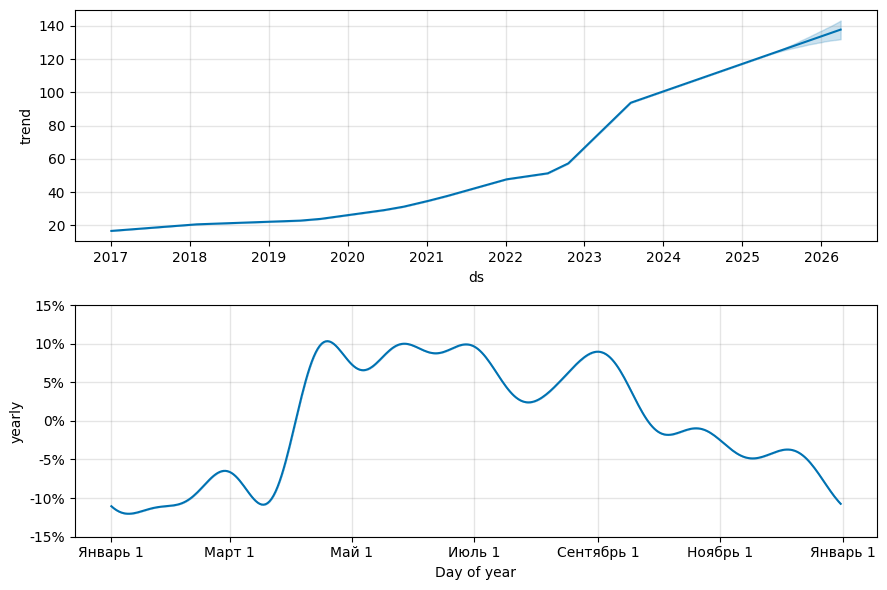

In [92]:
fig2 = model.plot_components(forecast)
plt.show()

Выполним оценку остатков созданной модели. Сначала построим QQ-диаграмму, а затем проведем анализ на нормальность с помощью статистических критериев. 

In [40]:
sample_in_prediction = model.make_future_dataframe(periods=1)
forecast = model.predict(sample_in_prediction)

# Получение остатков (только для исторических данных)
residuals = forecast['yhat'][:-1] - novo_prophet['y']

<Figure size 1000x600 with 0 Axes>

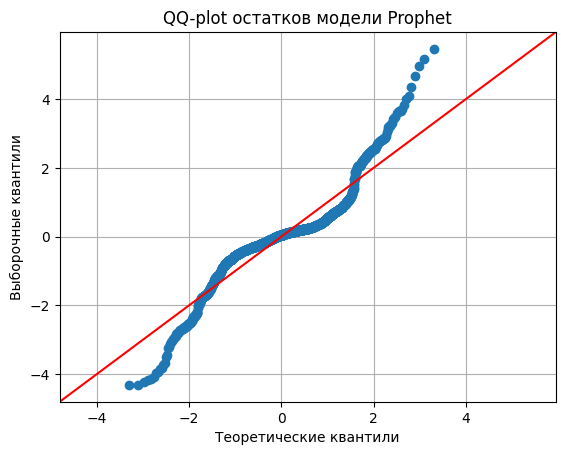

In [41]:
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ-plot остатков модели Prophet')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid(True)
plt.show()

QQ-диаграмма подтверждает отсутствие нормальности в распределении остатков модели. Это свидетельствует о том, что остатки не являются случайными. На их изменение оказывают влияние некоторые факторы, искажающие форму распределения.

Статистические критерии оценки нормальности подтверждают сделанное выше заключение.

In [42]:
normality_tests(residuals)

Checking normality with Shapiro-Wilk test: Not Normal
Checking normality with D'Agostino-Pearson test: Not Normal
Checking normality with Anderson-Darling test: Not Normal
Checking normality with Kolmogorov-Smirnov test: Not Normal


#### 1.2 Прогнозирование с помощью модели ARIMA

#### 1.2.1 Прогнозирование на суточных данных

Как уже обсуждалось выше, модель ARIMA не очень пригодна для прогнозирования на длительные интервалы времени. Возможно, не удастся получить приемлемых результатов, поскольку минимальный интервал прогнозирования в задании составляет 1 месяц.

Подготовим данные, указав их частотность

In [43]:
novo_close_day = novo_close.asfreq(freq="D", method="ffill")

Подберем гиперпараметры для модели, наилучшим образом описывающей временной ряд.

In [44]:
model_arima_day = pm.auto_arima(
    novo_close_day,
    seasonal=False,
    trace=True,
    suppress_warnings=True,
    stepwise=True
)
print(model_arima_day.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8746.034, Time=4.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8763.556, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8760.670, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8760.489, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8762.461, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8760.888, Time=1.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8760.499, Time=1.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8747.565, Time=3.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8747.600, Time=4.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8761.820, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8761.998, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8761.434, Time=1.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8744.968, Time=2.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8759.903, Time=0.55 sec
 ARIMA(2,1,1)(0

Проверим качество модели ARIMA при заданных значениях гиперпараметров (2, 1, 2), разбив весь временной ряд на фолды с помощью TimeSeriesSplit (n_splits=10)

In [45]:
tscv = TimeSeriesSplit(n_splits=10)
metrics_mape = []
metrics_rmse = []

for train_idx, test_idx in tscv.split(novo_close_day):
    train, test = novo_close_day.iloc[train_idx], novo_close_day.iloc[test_idx]
    
    # Обучение ARIMA на train
    model_arima_day = ARIMA(train, order=(2, 1, 2))  # Используйте подобранные (p,d,q)
    fitted_model_arima = model_arima_day.fit()
    
    # Прогноз на длину test
    forecast = fitted_model_arima.get_forecast(steps=len(test))
    pred = forecast.predicted_mean
    
    # Вычисляем MAPE для всего фолда (среднее по всем точкам)
    mape = np.mean(np.abs((test - pred) / test)) * 100
    rmse = np.sqrt(mean_squared_error(test, pred))
    metrics_mape.append(mape)
    metrics_rmse.append(rmse)
    print(f"MAPE для fold: {mape:.2f}%, RMSE для fold: {rmse:.2f}")

print(f"Средний MAPE: {np.mean(metrics_mape):.2f}%, средний RMSE: {np.mean(metrics_rmse):.2f}")

MAPE для fold: 4.31%, RMSE для fold: 1.35
MAPE для fold: 4.79%, RMSE для fold: 1.24
MAPE для fold: 5.57%, RMSE для fold: 1.68
MAPE для fold: 10.92%, RMSE для fold: 3.57
MAPE для fold: 5.53%, RMSE для fold: 2.93
MAPE для fold: 17.54%, RMSE для fold: 9.41
MAPE для fold: 6.29%, RMSE для fold: 4.37
MAPE для fold: 15.40%, RMSE для fold: 15.28
MAPE для fold: 20.48%, RMSE для fold: 29.55
MAPE для fold: 40.02%, RMSE для fold: 42.09
Средний MAPE: 13.08%, средний RMSE: 11.15


Метрики качества прогноза, как и в случае модели Prophet, довольно плохие. Как и в случае, модели Prophet, значения MAPE и RMSE, в целом, неплохи для первой половины временного ряда, но сильно ухудшаются на второй половине вследствие резких изменений стоимости акций, что модели трудно прогнозировать.

Выполним предсказание с помощью ARIMA. Следует сразу учесть, что модель ARIMA способна прогнозировать лишь на несколько периодов вперед, поэтому не стоит рассчитывать на высокую предсказательную способность на интервале 30, 90, 180 и 365 дней.

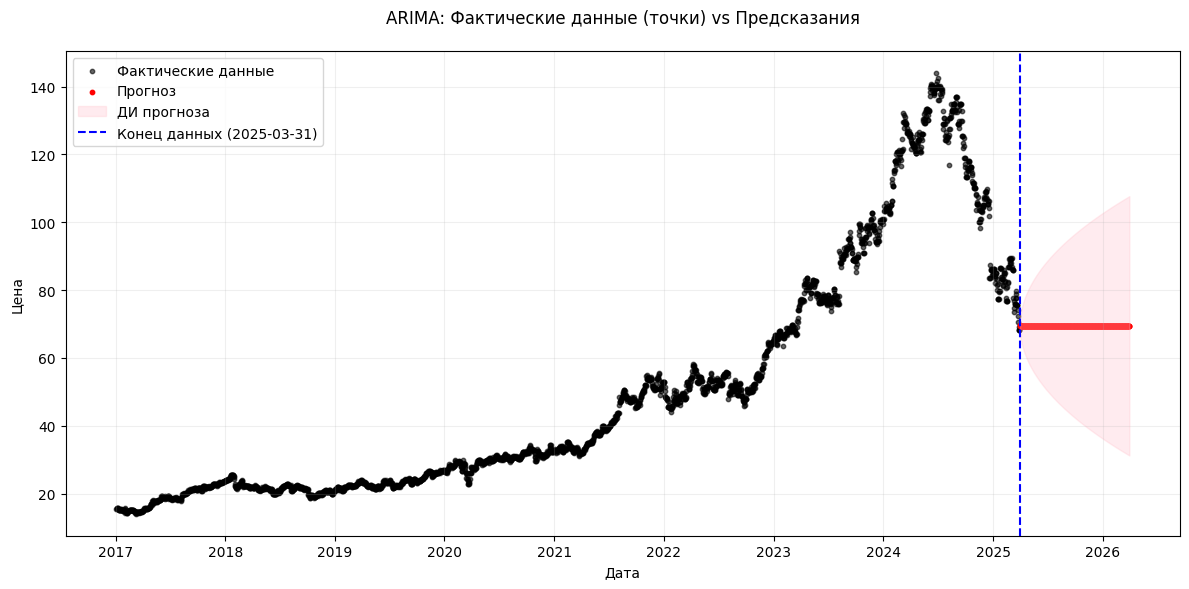

In [46]:
# Фитируем модель на всех данных
final_model_arima = ARIMA(novo_close_day, order=(2, 1, 2))
fitted_model = final_model_arima.fit()

# Получаем предсказания для исторических данных
historical_pred = fitted_model_arima.get_prediction(start=novo_close_day.index[1], end=novo_close_day.index[-1])
historical_pred_values = historical_pred.predicted_mean
historical_conf_int = historical_pred.conf_int()

# Периоды для прогноза: 30, 90, 180, 365 дней
periods = [30, 90, 180, 365]
forecast = fitted_model.get_forecast(steps=max(periods))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Визуализация
plt.figure(figsize=(12, 6))

# Фактические данные в виде точек (scatter)
plt.scatter(novo_close_day.index, novo_close_day.values, 
            label='Фактические данные', color='black', alpha=0.6, s=10)

# Прогноз на будущее (сплошная красная линия + розовый ДИ)
forecast_dates = pd.date_range(start=novo_close_day.index[-1], periods=max(periods)+1, freq='D')[1:]
plt.scatter(forecast_dates, forecast_values[:max(periods)], 
         label='Прогноз', color='red', s=10)
plt.fill_between(
    forecast_dates,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3, label='ДИ прогноза'
)

# 4. Вертикальная разделительная линия
last_date = novo_close_day.index[-1]
plt.axvline(x=last_date, color='blue', linestyle='--', 
            label=f'Конец данных ({last_date.strftime("%Y-%m-%d")})')

# 5. Настройки графика
plt.title('ARIMA: Фактические данные (точки) vs Предсказания', pad=20)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Как видно из диаграммы, модель не справилась с предсказанием. Все четыре прогноза наложились друг на друга. По сути, модель не обучилась изменению стоимости акций. Прежде всего, вследствие отсутствия ярко выраженной сезонности и тренда.

#### 1.2.2 Прогнозирование на месячных данных

Поскольку модель ARIMA позволяет предсказывать лишь на несколько (1-3) периода вперед, попробуем выполнить прогноз, используя в качестве исторических данных месячные, а не суточные данные. В таком случае нам придется строить прогноз на 1, 3, 6 и 12 периодов.

Подготовим датасет для месячных данных. В данном случае в качестве стоимости акции примем среднее значение акции за соответствующий месяц

In [47]:
df_novo_month = df_novo.reset_index()
df_novo_month['Year-Month'] = df_novo_month["Date"].dt.to_period('M')

# Группируем по месяцу и считаем среднюю цену
monthly_avg = df_novo_month.groupby('Year-Month')['Close'].mean().rename('Close_average').to_frame()
monthly_avg = monthly_avg.to_timestamp()
print(monthly_avg)

            Close_average
Year-Month               
2017-01-01      15.266312
2017-02-01      14.847037
2017-03-01      14.552979
2017-04-01      15.785426
2017-05-01      17.737310
...                   ...
2024-11-01     104.374100
2024-12-01      99.691651
2025-01-01      82.820912
2025-02-01      83.871639
2025-03-01      77.526396

[99 rows x 1 columns]


Выполним подбор гиперпараметров для модели ARIMA

In [48]:
model_arima = pm.auto_arima(
    monthly_avg,
    seasonal=False,
    trace=True,
    suppress_warnings=True,
    stepwise=True
)
print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=551.409, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=562.922, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=552.672, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=553.647, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=563.150, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=551.625, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=551.638, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=545.013, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=543.014, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=541.014, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=553.778, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=543.014, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=545.014, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=539.076, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=552.5

Используя гиперпараметры, подобранные с помощью auto_arima (3, 1, 0), выполним оценку качества модели на фолдах, полученных с помощью TimeSeriesSplit (n_splits=10). Как и в предыдущем случае, рассчитываем метрики MAPE и RMSE для каждого фолда и в среднем для всего временного ряда.

In [49]:
tscv = TimeSeriesSplit(n_splits=10)
metrics_mape = []
metrics_rmse = []

for train_idx, test_idx in tscv.split(monthly_avg):
    train, test = monthly_avg.iloc[train_idx], monthly_avg.iloc[test_idx]
    
    model_arima = ARIMA(train, order=(3, 1, 0))
    fitted_model = model_arima.fit()
    
    forecast = fitted_model.get_forecast(steps=len(test))
    pred = forecast.predicted_mean

    mape = np.mean(np.abs((test.values.reshape(-1) - pred.values.reshape(-1)) / test.values.reshape(-1))) * 100
    rmse = np.sqrt(mean_squared_error(test.values.reshape(-1), pred.values.reshape(-1)))
    metrics_mape.append(mape)
    metrics_rmse.append(rmse)
    print(f"MAPE для fold: {mape:.2f}%, RMSE для fold: {rmse:.2f}")

print(f"Средний MAPE: {np.mean(metrics_mape):.2f}%, средний RMSE: {np.mean(metrics_rmse):.2f}")

MAPE для fold: 6.00%, RMSE для fold: 1.58
MAPE для fold: 7.69%, RMSE для fold: 1.94
MAPE для fold: 4.94%, RMSE для fold: 1.68
MAPE для fold: 8.99%, RMSE для fold: 3.04
MAPE для fold: 6.55%, RMSE для fold: 3.22
MAPE для fold: 16.89%, RMSE для fold: 8.89
MAPE для fold: 8.53%, RMSE для fold: 6.16
MAPE для fold: 14.70%, RMSE для fold: 14.33
MAPE для fold: 16.76%, RMSE для fold: 25.44
MAPE для fold: 44.83%, RMSE для fold: 47.56
Средний MAPE: 13.59%, средний RMSE: 11.38


Также отмечаем плохие метрики, особенно при прогнозировании последних фолдов для временного ряда.

Выполним прогнозирование на будущие периоды (1, 3, 6, 12 месяцев).

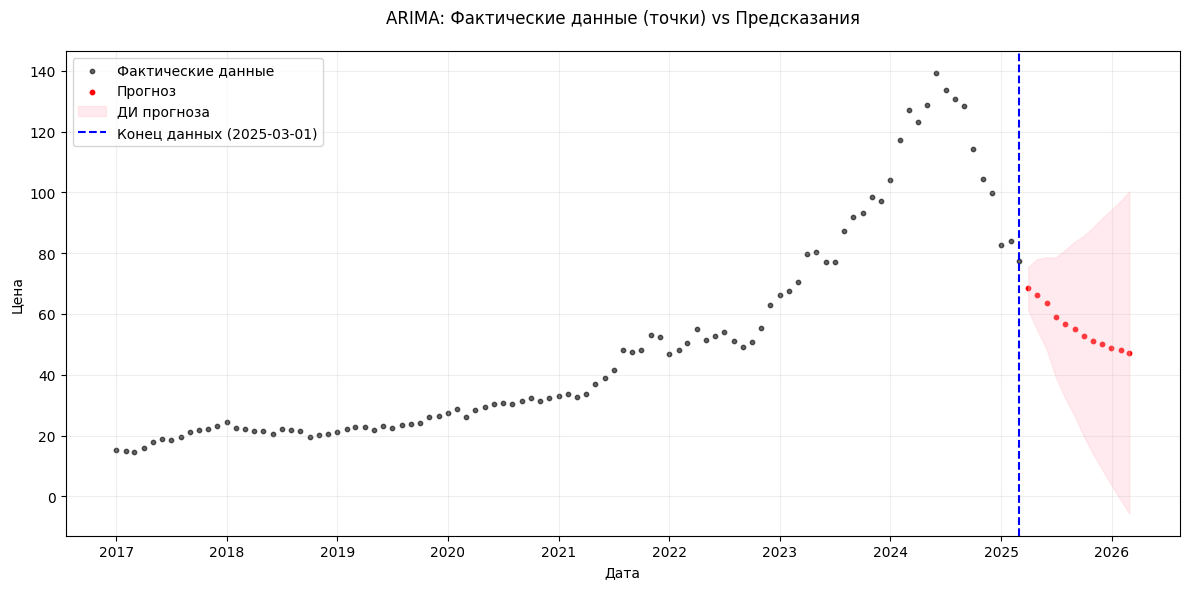

In [50]:
final_model_arima = ARIMA(monthly_avg, order=(3, 1, 0))
fitted_model = final_model_arima.fit()

historical_pred = fitted_model.get_prediction(start=monthly_avg.index[1], end=monthly_avg.index[-1])
historical_pred_values = historical_pred.predicted_mean
historical_conf_int = historical_pred.conf_int()

periods = [1, 3, 6, 12]
forecast = fitted_model.get_forecast(steps=max(periods))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


plt.figure(figsize=(12, 6))

plt.scatter(monthly_avg.index, monthly_avg.values, 
            label='Фактические данные', color='black', alpha=0.6, s=10)

forecast_dates = pd.date_range(start=monthly_avg.index[-2], periods=max(periods)+1, freq='M')[1:]
plt.scatter(forecast_dates, forecast_values[:max(periods)], 
         label='Прогноз', color='red', s=10)

plt.fill_between(
    forecast_dates,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3, label='ДИ прогноза'
)

last_date = monthly_avg.index[-1]
plt.axvline(x=last_date, color='blue', linestyle='--', 
            label=f'Конец данных ({last_date.strftime("%Y-%m-%d")})')

plt.title('ARIMA: Фактические данные (точки) vs Предсказания', pad=20)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Отмечаем иной вид прогноза в сравнении с дневными данными. Модель прогнозирует затухающий нисходящий тренд стоимости акций NVO (это даже совпадает с реальными данными за апрель 2025 г.). 

Построим QQ-диаграмму для остатков модели

<Figure size 1000x600 with 0 Axes>

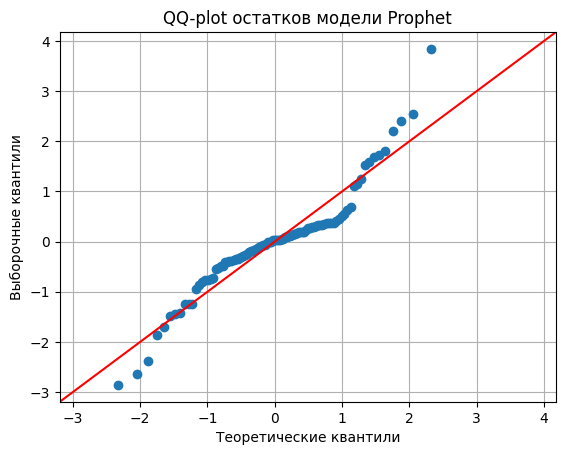

In [51]:
plt.figure(figsize=(10, 6))
sm.qqplot(fitted_model.resid, line='45', fit=True)
plt.title('QQ-plot остатков модели Prophet')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid(True)
plt.show()

Эта QQ-диаграмма, кажется, гораздо ближе к нормальности, чем QQ-диаграмма, построенная для модели Prophet. Тем не менее, нормального распределения остатков не наблюдается. Статистические тесты на нормальность подтверждают это заключение.

In [52]:
normality_tests(fitted_model.resid)

Checking normality with Shapiro-Wilk test: Not Normal
Checking normality with D'Agostino-Pearson test: Not Normal
Checking normality with Anderson-Darling test: Not Normal
Checking normality with Kolmogorov-Smirnov test: Not Normal


### Заключение

Выполнено прогнозирование временного ряда изменения стоимости ценной бумаги NVO (компания Novo Nordisk) с использованием двух моделей, Prophet и ARIMA. Необходимо отметить низкие метрики качества прогнозной модели. Это обусловлено, прежде всего, характером изменения стоимости ценной бумаги. Она не имеет выраженной сезонности, тренда и циклов, что характерно для временных рядов изменения стоимости ценных бумаг. Т.е. изменение стоимости ценной бумаги мало прогнозируемо. И если в период отсутствия резких изменений стоимости модели позволяют проводить более-менее качественное моделирование, то период роста/падения стоимости отличаются низкой прогнозируемостью. В связи с этим прогнозы моделей на будушие периоды следует рассматривать как ненадежные.